In [824]:
import pandas as pd
import numpy as np 
import random
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestRegressor


data = pd.read_csv("C:/ProgramData/MySQL/MySQL Server 5.7/Uploads/result.csv", na_values = 'NULL')
pd.set_option('display.max_columns', None)
data['zipcode'] = data['zipcode'].apply(str)
data2 = data.ix[:,(0,3,4,5,9,10,11,12,16,21,26,27,28,29,31,32,33,34,35,36,44,45,1)]
data2 = data2[(data2['beds'] > 0)]
np.random.seed(123)
data2 = data2.ix[np.random.permutation(len(data2['zipcode']))]
data2 = data2.reset_index(drop = True)
data3 = data2[(data2['sale_price'] < 10000000) & (data2['sale_price'] > 100000)]
data3 = data3[(data3['city'] == 'Newark')|(data3['city'] == 'Princeton')]
data3 = data3.drop('zillowhomeid',axis = 1)
data4 = pd.get_dummies(data3, dummy_na = False)


random.seed(123)
x = random.sample(range(len(data4)), len(data4))
x = np.array(x)
msk = x < 0.75*len(data4)

train = data4[msk].reset_index(drop = True)
train2 = train.drop('sale_price', axis=1)
train2_target = train['sale_price']

test = data4[~msk].reset_index(drop = True)
test2 = test.drop('sale_price', axis=1)
test2_target = test['sale_price']

"""
splits = train_test_split(data4, train_size=0.8, random_state=42)
train = splits[0].reset_index(drop = True)
train2 = train.drop('sale_price', axis=1)
train2_target = train['sale_price']
test = splits[1].reset_index(drop = True)
test2 = test.drop('sale_price', axis=1)
test2_target = test['sale_price']
"""
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp = imp.fit(train2)
train2_imp = imp.transform(train2)

imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp = imp.fit(test2)
test2_imp = imp.transform(test2)

In [825]:
rf = RandomForestRegressor(n_estimators=500, max_depth=6)
rf.fit(train2_imp, train2_target)
preds2 = rf.predict(test2_imp)
from sklearn.metrics import mean_squared_error
RMSE2 = mean_squared_error(test2_target, preds2)**0.5
RMSE2

77266.561037345746

In [826]:
import xgboost as xgb

param = {'objective':'reg:linear', 'eta': 0.05, 'silent':0, 'eval_metric':'rmse', 'subsample':0.5,
        'colsample_bytree':0.5, 'max_depth':5, 'min_child_weight':4,'gamma':2}
num_round = 140
xg_train = xgb.DMatrix(train2_imp, label=train2_target)
xg_test = xgb.DMatrix(test2_imp)
bst = xgb.train(param, xg_train, num_round)
preds = bst.predict(xg_test)
RMSE2 = mean_squared_error(test2_target, preds)**0.5
RMSE2

77722.102017048761

In [827]:
data_comp = pd.concat((pd.DataFrame(preds), pd.DataFrame(test2_target),test2), axis = 1)
data_comp.head(20)

,0,sale_price,beds,baths,floorsize,lot,built_in,alltimeviews,attic,condo,dishwasher,microwave,rangeoven,refrigerator,washer,dryer,stories,unitcount,zipcode_7102,zipcode_7103,zipcode_7104,zipcode_7105,zipcode_7106,zipcode_7107,zipcode_7108,city_Newark,state_NJ,exteriormaterial_Brick,exteriormaterial_Cement concrete,exteriormaterial_Composition,exteriormaterial_Metal,exteriormaterial_Other,exteriormaterial_Shingle,exteriormaterial_Stone,exteriormaterial_Stucco,exteriormaterial_Vinyl,exteriormaterial_Wood,flooring_Carpet,flooring_Ceramic Tile,flooring_Concrete,flooring_Hardwood,flooring_Laminate,flooring_Linoleum / Vinyl,flooring_Mixed,flooring_Parquet,flooring_See Remarks,flooring_Stone,flooring_Tile
0,258945.281250,339000.0,3.0,2.0,2708.0,NaN,NaN,1767.0,NaN,NaN,1.0,NaN,1.0,1.0,1.0,NaN,2.0,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,213014.671875,215000.0,3.0,3.0,2393.0,4791.0,1926.0,311.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,388814.750000,429000.0,6.0,5.0,2898.0,4356.0,1998.0,1275.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,229027.703125,120000.0,5.0,3.0,2789.0,3049.0,1895.0,1276.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,278708.250000,193000.0,6.0,5.0,1520.0,2500.0,2006.0,7438.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,230622.468750,285000.0,7.0,3.0,2872.0,2378.0,1960.0,236.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,207712.437500,409000.0,5.0,3.0,2332.0,3484.0,1900.0,1122.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,186326.875000,219000.0,3.0,2.0,2604.0,NaN,2005.0,1609.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,198581.625000,230000.0,7.0,3.0,2036.0,2500.0,1957.0,1088.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,2.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,222743.531250,220000.0,3.0,1.0,1738.0,2500.0,1907.0,902.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [828]:
import re
import matplotlib

importance = bst.get_fscore()
imp = pd.DataFrame(importance.items(), columns = ['Feature','Score'])
k = imp.iloc[:,0]
def stringer(string1):
    return int(re.search(r'\d+', string1).group())
k2 = np.array(map(stringer, k))
names = train2.columns.values
features = names[k2]
imp['Score'] = imp['Score'] / imp['Score'].sum()
imp['Feature'] = features
imp = imp.sort_values(by = 'Score', ascending = False).reset_index(drop = True)

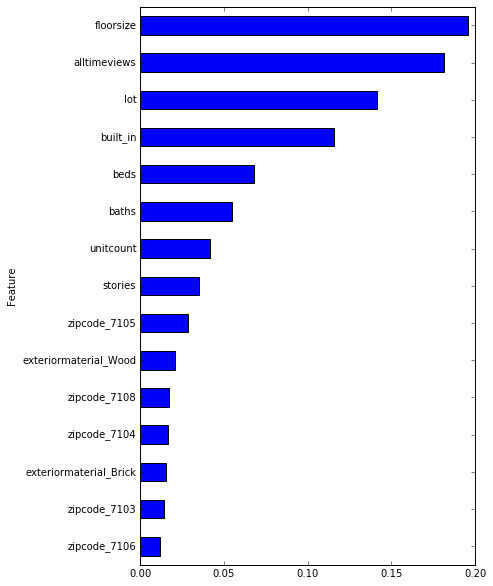

In [829]:
%matplotlib inline
ax = imp.iloc[0:15,:].plot(kind='barh', x='Feature', y='Score', legend=False, figsize = (6, 10))
ax.invert_yaxis()

In [830]:
from xgbImportance import featureImportance
featureImportance(bst,train2,15)

ImportError: cannot import name featureImportance

In [832]:
data2.shape

(3058, 23)

In [608]:
test2.head(10)

,beds,baths,floorsize,lot,built_in,dishwasher,microwave,rangeoven,refrigerator,washer,dryer,stories,unitcount,zipcode_7102,zipcode_7103,zipcode_7104,zipcode_7105,zipcode_7106,zipcode_7107,zipcode_7108,city_Newark,state_NJ,street_10TH,street_10th,street_11TH,street_11th,street_12TH,street_12th,street_13TH,street_13th,street_14TH,street_14th,street_15th,street_16TH,street_16th,street_17TH,street_17th,street_18TH,street_18th,street_19TH,street_19th,street_20TH,street_20th,street_2nd,street_3RD,street_3rd,street_4th,street_5TH,street_5th,street_6th,street_7TH,street_7th,street_8TH,street_8th,street_9TH,street_9th,street_Adams,street_Alexander,street_Alpine,street_Alyea,street_Ann,street_Arlington,street_Bergen,street_Blum,street_Boylan,street_Brill,street_Broad,street_Bruen,street_Bryant,street_Buren,street_Calumet,street_Camp,street_Chambers,street_Charles,street_Chestnut,street_Clover,street_Coeyman,street_Colleen,street_Columbia,street_Cortland,street_Crane,street_Crawford,street_Cutler,street_Cypress,street_Darcy,street_Delancey,street_Dickerson,street_Dover,street_Duryea,street_Elliott,street_Elm,street_Esther,street_Ferdinand,street_Ferguson,street_Ferry,street_Fillmore,street_Foundry,street_Francis,street_Freeman,street_Garrison,street_Garside,street_George,street_Gotthardt,street_Gouverneur,street_Governor,street_Grove,street_Halleck,street_Halstead,street_Hawkins,street_Hecker,street_Hensler,street_Holland,street_Houston,street_Hudson,street_Hunterdon,street_Irving,street_Jackson,street_James,street_Jefferson,street_Johnson,street_Kearny,street_Kent,street_Kinney,street_Komorn,street_Kossuth,street_Lafayette,street_Lake,street_Lang,street_Leslie,street_Lexington,street_Linden,street_Longworth,street_Main,street_Malvern,street_Market,street_Marne,street_Mcwhorter,street_Mead,street_Merchant,street_Montrose,street_Mulberry,street_Napoleon,street_New,street_Niagara,street_Nichols,street_Norfolk,street_Norwood,street_Oliver,street_Oraton,street_Pacific,street_Palm,street_Parker,street_Paterson,street_Pennington,street_Pierce,street_Plymouth,street_Polk,street_Prospect,street_Providence,street_Read,street_Richmond,street_Ricord,street_Ridge,street_Rome,street_Rowland,street_Runyon,street_Salem,street_Schalk,street_Scofield,street_Scott,street_Seabury,street_Silver,street_Smith,street_South,street_Spruce,street_Stone,street_Summit,street_Taylor,street_Telford,street_Tichenor,street_Underwood,street_Union,street_Valley,street_Vesey,street_Vincent,street_Vine,street_Voorhees,street_Wall,street_Walnut,street_Warwick,street_Waydell,street_Webster,exteriormaterial_Brick,exteriormaterial_Cement concrete,exteriormaterial_Composition,exteriormaterial_Metal,exteriormaterial_Other,exteriormaterial_Shingle,exteriormaterial_Stone,exteriormaterial_Stucco,exteriormaterial_Vinyl,exteriormaterial_Wood,flooring_Carpet,flooring_Ceramic Tile,flooring_Concrete,flooring_Hardwood,flooring_Laminate,flooring_Linoleum / Vinyl,flooring_Mixed,flooring_Parquet,flooring_See Remarks,flooring_Stone,flooring_Tile
13,3.0,2.0,2708.0,NaN,NaN,1.0,NaN,1.0,1.0,1.0,NaN,2.0,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,3.0,3.0,2393.0,4791.0,1926.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.